[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


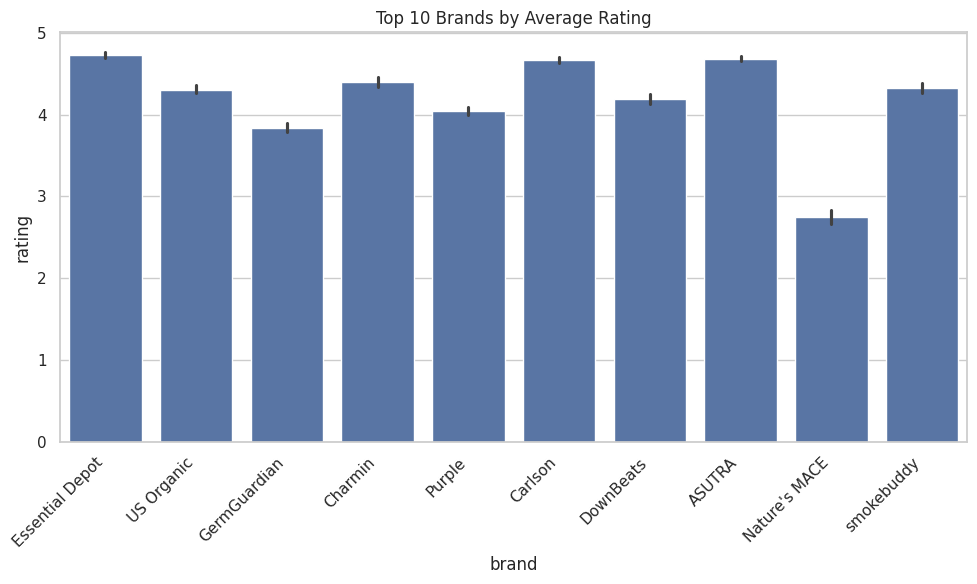

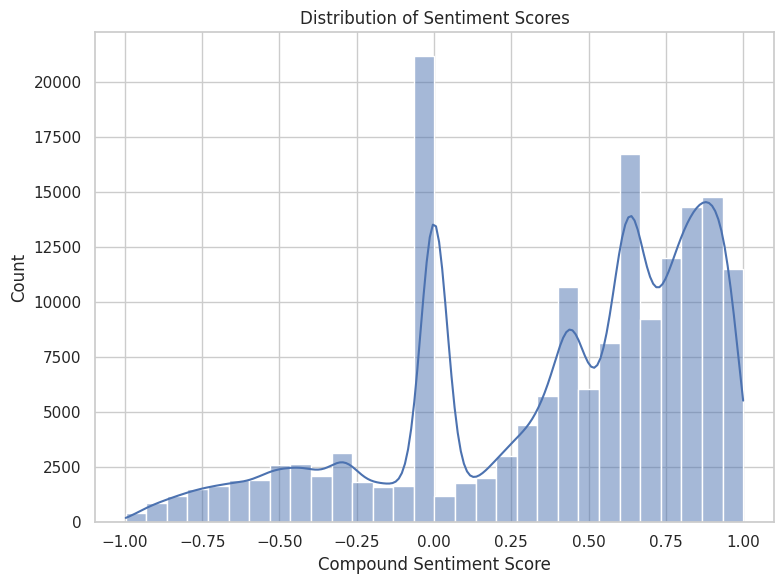

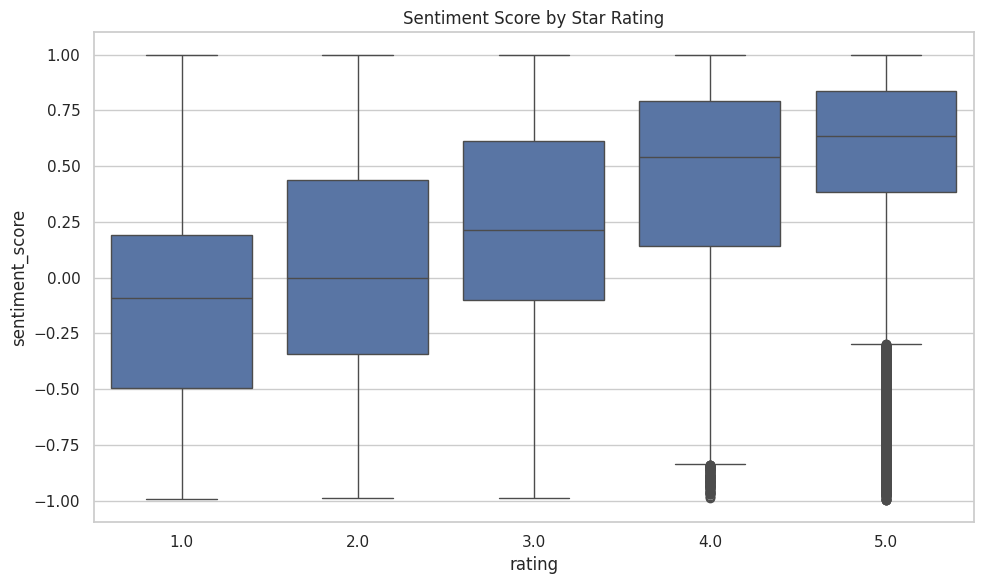

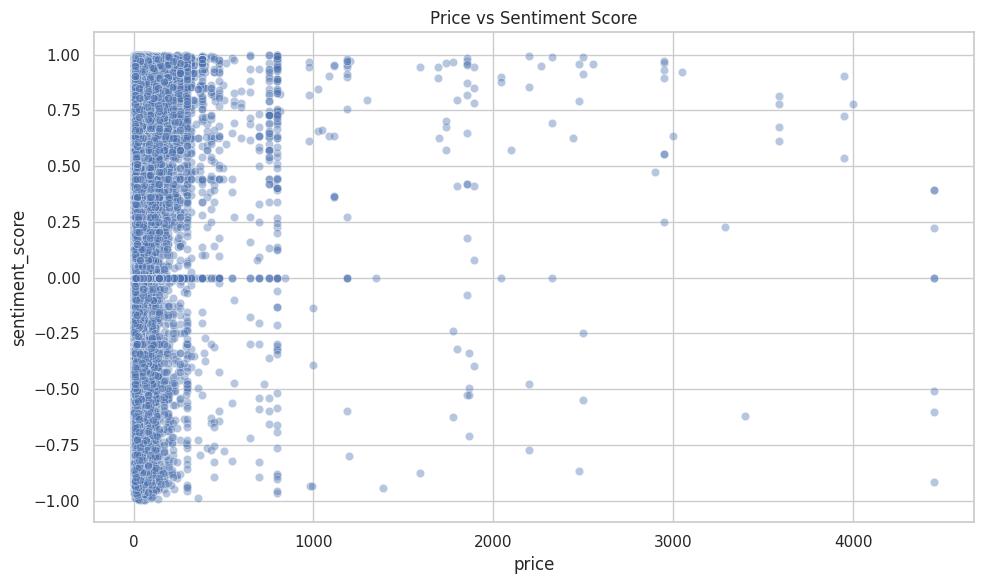

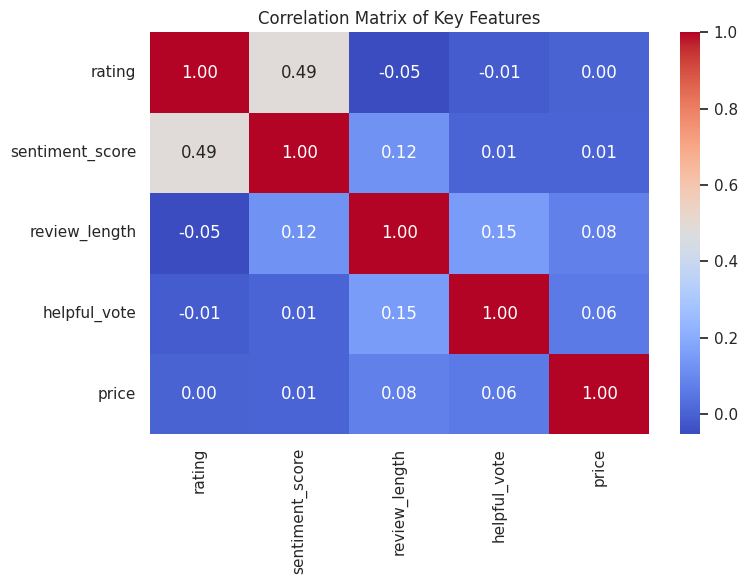

In [5]:
# 📦 Imports
import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import numpy as np

# Download VADER (only required once)
nltk.download('vader_lexicon')

# 📁 Function to read compressed JSONL
def read_jsonl_gz(file_path):
    data = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# 🔄 Load datasets
reviews = read_jsonl_gz("Health_and_Personal_Care.jsonl.gz")
meta = read_jsonl_gz("meta_Health_and_Personal_Care.jsonl.gz")

# 🧹 Clean & prepare
reviews = reviews[['rating', 'title', 'text', 'asin', 'parent_asin', 'helpful_vote', 'verified_purchase']]
meta['brand'] = meta['store']  # Use 'store' as a substitute for brand
meta = meta[['parent_asin', 'title', 'brand', 'price', 'average_rating', 'rating_number']]

# Merge datasets on parent_asin
df = pd.merge(reviews, meta, on='parent_asin', how='inner')

# Drop missing key values
df.dropna(subset=['text', 'rating', 'brand', 'price'], inplace=True)

# Clean text and engineer features
df['review_length'] = df['text'].apply(lambda x: len(x.split()))
df['helpful_vote'] = pd.to_numeric(df['helpful_vote'], errors='coerce').fillna(0)

# 🔍 Sentiment Analysis
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# 🧠 Top brands by review count
top_brands = df['brand'].value_counts().head(10).index.tolist()
brand_df = df[df['brand'].isin(top_brands)]

# 🎨 Visualisation setup
sns.set(style="whitegrid")

# 📊 1. Bar Chart: Top brands by average rating
plt.figure(figsize=(10, 6))
sns.barplot(data=brand_df, x='brand', y='rating', estimator=np.mean)
plt.title('Top 10 Brands by Average Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 📉 2. Histogram: Sentiment score distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['sentiment_score'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.tight_layout()
plt.show()

# 📦 3. Box Plot: Sentiment by Star Rating
plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='sentiment_score', data=df)
plt.title('Sentiment Score by Star Rating')
plt.tight_layout()
plt.show()

# 💸 4. Scatter: Price vs Sentiment
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='sentiment_score', data=df, alpha=0.4)
plt.title('Price vs Sentiment Score')
plt.tight_layout()
plt.show()

# 🧮 5. Correlation Heatmap
corr = df[['rating', 'sentiment_score', 'review_length', 'helpful_vote', 'price']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Features')
plt.tight_layout()
plt.show()


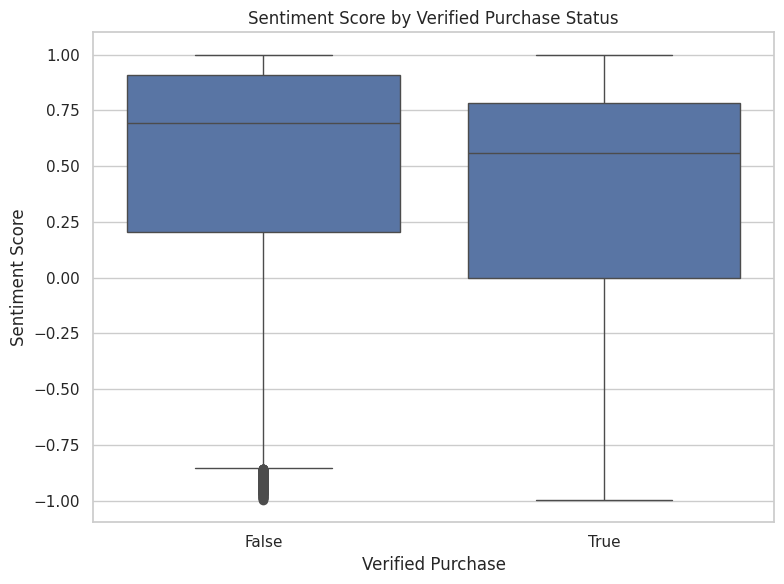

In [6]:
# Sentiment Score by Verified Purchase
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x='verified_purchase', y='sentiment_score', data=df)
plt.title('Sentiment Score by Verified Purchase Status')
plt.xlabel('Verified Purchase')
plt.ylabel('Sentiment Score')
plt.tight_layout()
plt.show()

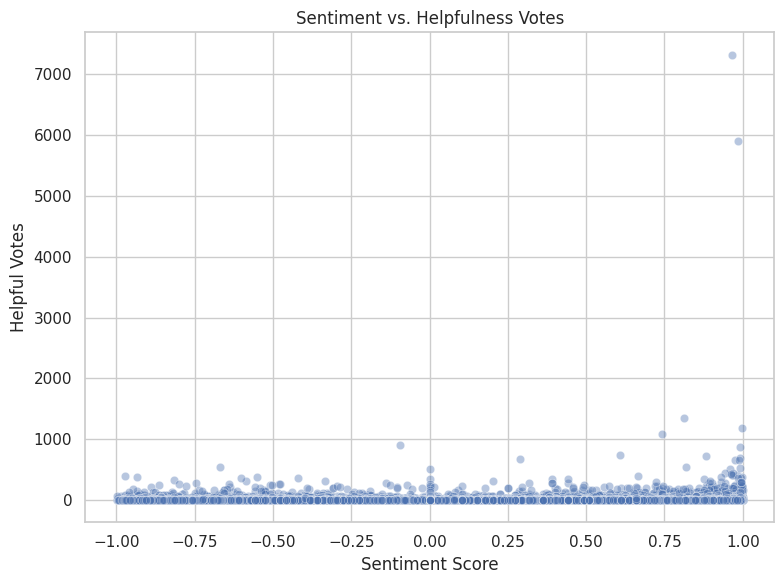

In [22]:
# Sentiment vs Helpfulness (Vote Count)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sentiment_score', y='helpful_vote', data=df, alpha=0.4)
plt.title('Sentiment vs. Helpfulness Votes')
plt.xlabel('Sentiment Score')
plt.ylabel('Helpful Votes')
plt.tight_layout()
plt.show()

In [8]:
# Top Positive and Negative Reviews
print("🌟 Most Positive Review:\n", df.loc[df['sentiment_score'].idxmax()][['rating', 'text']])
print("\n💢 Most Negative Review:\n", df.loc[df['sentiment_score'].idxmin()][['rating', 'text']])

🌟 Most Positive Review:
 rating                                                  5.0
text      UPDATE:  So I've had my forearm crutches for a...
Name: 215787, dtype: object

💢 Most Negative Review:
 rating                                                  5.0
text      I just reordered two more bottles because thes...
Name: 435671, dtype: object


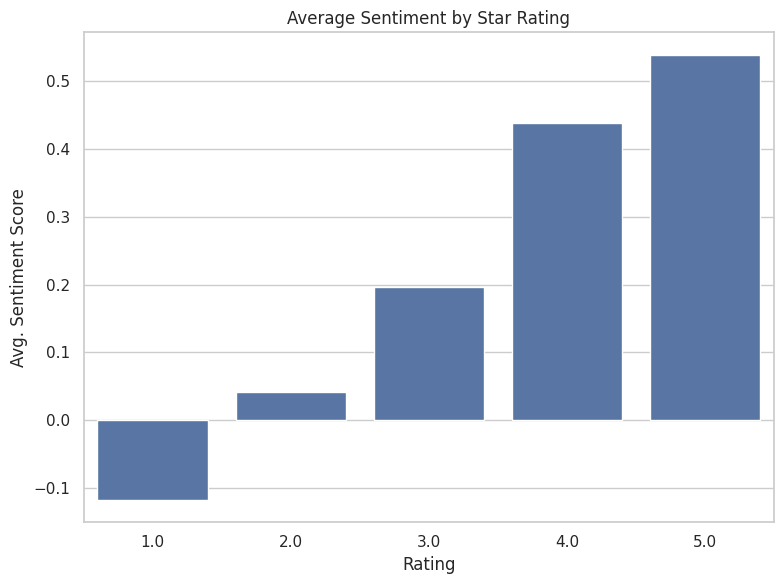

In [9]:
# Average Sentiment by Rating (Bar Plot)
rating_sentiment = df.groupby('rating')['sentiment_score'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='rating', y='sentiment_score', data=rating_sentiment)
plt.title('Average Sentiment by Star Rating')
plt.xlabel('Rating')
plt.ylabel('Avg. Sentiment Score')
plt.tight_layout()
plt.show()

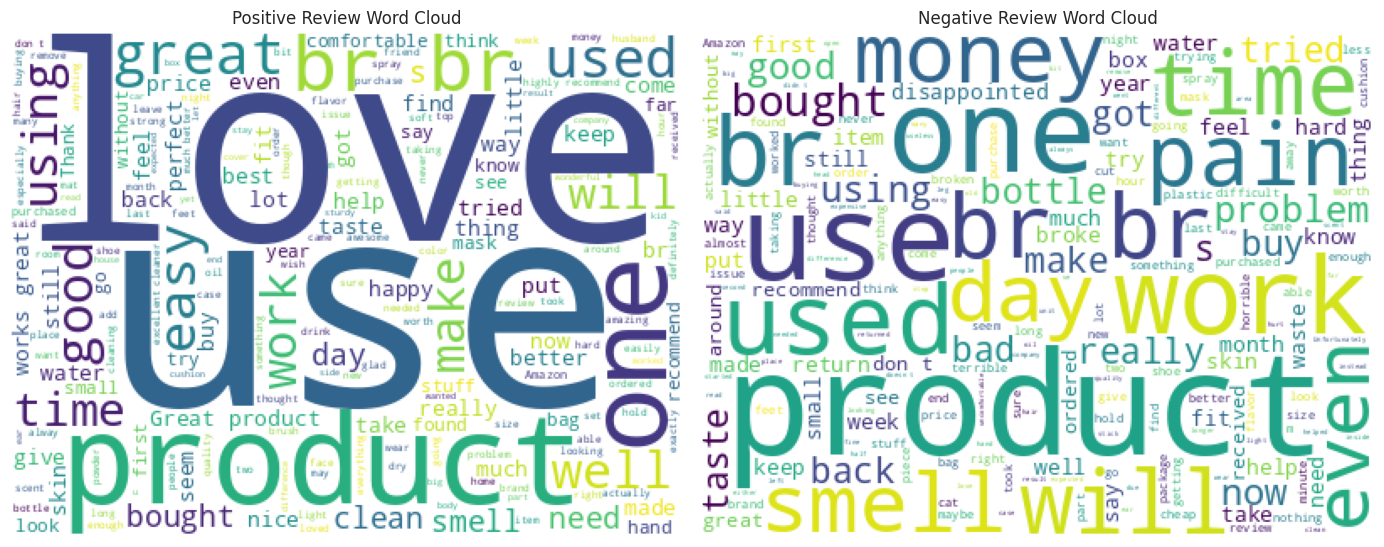

In [10]:
# Word Cloud of Positive vs Negative Reviews
from wordcloud import WordCloud

positive_reviews = ' '.join(df[df['sentiment_score'] > 0.6]['text'])
negative_reviews = ' '.join(df[df['sentiment_score'] < -0.3]['text'])

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=400, height=300, background_color='white').generate(positive_reviews))
plt.title('Positive Review Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=400, height=300, background_color='white').generate(negative_reviews))
plt.title('Negative Review Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()

<ipython-input-11-b27a02393505>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigram_freq, x='count', y='bigram', palette='viridis')


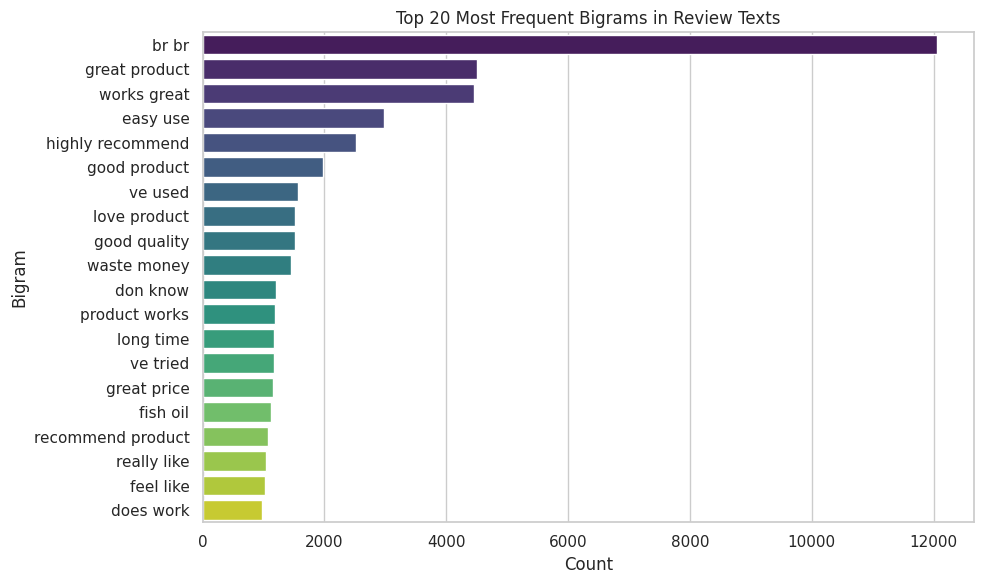

In [11]:
# Top Bigrams in Review Texts
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter reviews with meaningful text
cleaned_reviews = df['text'].dropna().astype(str)

# Use CountVectorizer to extract bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)
X = vectorizer.fit_transform(cleaned_reviews)

# Sum up the counts of each bigram
bigrams = vectorizer.get_feature_names_out()
counts = X.sum(axis=0).A1
bigram_freq = pd.DataFrame({'bigram': bigrams, 'count': counts})
bigram_freq = bigram_freq.sort_values(by='count', ascending=False)

# Plot the top bigrams
plt.figure(figsize=(10, 6))
sns.barplot(data=bigram_freq, x='count', y='bigram', palette='viridis')
plt.title('Top 20 Most Frequent Bigrams in Review Texts')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.tight_layout()
plt.show()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


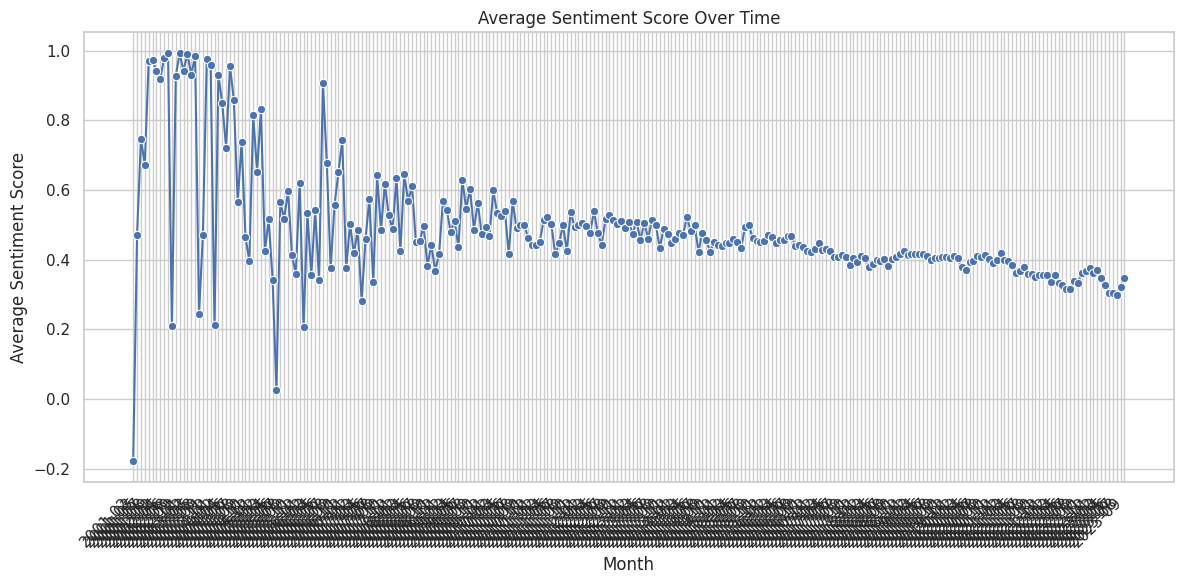

In [12]:
# Average Sentiment Score Over Time
import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER
nltk.download('vader_lexicon')

# Load compressed jsonl files
def read_jsonl_gz(filepath):
    data = []
    with gzip.open(filepath, 'rt', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Load datasets
reviews = read_jsonl_gz("Health_and_Personal_Care.jsonl.gz")
meta = read_jsonl_gz("meta_Health_and_Personal_Care.jsonl.gz")

# Prepare data
meta['brand'] = meta['store']
meta = meta[['parent_asin', 'title', 'brand', 'price', 'average_rating', 'rating_number']]
reviews = reviews[['rating', 'title', 'text', 'asin', 'parent_asin', 'helpful_vote', 'verified_purchase', 'timestamp']]
df = pd.merge(reviews, meta, on='parent_asin', how='inner')
df.dropna(subset=['text', 'timestamp'], inplace=True)

# Convert timestamp from ms to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df['review_month'] = df['timestamp'].dt.to_period('M')

# Sentiment analysis
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Aggregate sentiment by month
sentiment_over_time = df.groupby('review_month')['sentiment_score'].mean().reset_index()
sentiment_over_time['review_month'] = sentiment_over_time['review_month'].astype(str)

# Plot sentiment over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_over_time, x='review_month', y='sentiment_score', marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Average Sentiment Score Over Time')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.tight_layout()
plt.show()

Top terms per cluster:

Cluster 1: br, just, like, use, product, time, great, really, using, good
Cluster 2: good, product, quality, price, work, easy, great, smells, flavor, love
Cluster 3: love, product, use, like, work, just, easy, used, great, nice
Cluster 4: works, great, good, really, product, use, expected, better, like, fine
Cluster 5: great, product, price, work, love, use, value, flavor, quality, taste


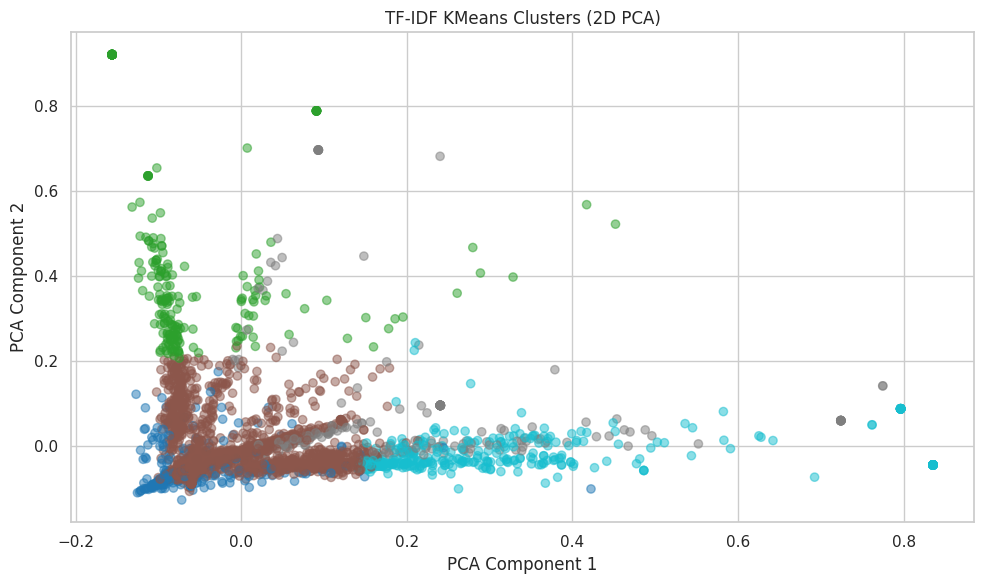

In [13]:
# Clustering Review Themes Using TF-IDF and KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

sample_reviews = df['text'].dropna().astype(str).sample(5000, random_state=42) # Sample 5000 reviews for performance

# TF-IDF vectorisation
vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
X = vectorizer.fit_transform(sample_reviews)

# KMeans clustering
k = 5  # number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Top terms per cluster
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

print("Top terms per cluster:\n")
for i in range(k):
    print(f"Cluster {i+1}: ", end="")
    print(", ".join([terms[ind] for ind in order_centroids[i, :10]]))

# Optional: PCA for 2D visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='tab10', alpha=0.5)
plt.title("TF-IDF KMeans Clusters (2D PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

Top words per topic:

Topic 1: product, love, great, good, use, water, used, best, easy, nice
Topic 2: product, ve, pain, using, use, taking, years, really, working, help
Topic 3: work, money, just, does, time, product, did, use, br, comfortable
Topic 4: great, works, use, good, easy, quality, perfect, like, little, just
Topic 5: br, like, hair, just, use, skin, really, don, product, better


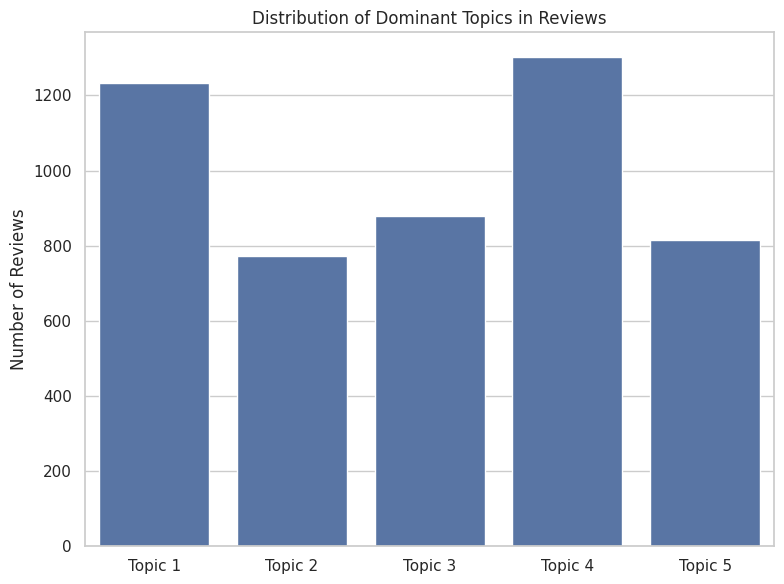

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Sample 5000 reviews to keep it performant
sample_reviews = df['text'].dropna().astype(str).sample(5000, random_state=42)

# Vectorize text using CountVectorizer (LDA works better than with TF-IDF)
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=10)
X = vectorizer.fit_transform(sample_reviews)

# Fit LDA model
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

# Display top words per topic
terms = vectorizer.get_feature_names_out()
print("Top words per topic:\n")
for i, topic in enumerate(lda.components_):
    top_words = [terms[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {i+1}: {', '.join(top_words)}")

topic_dist = lda.transform(X)
dominant_topics = topic_dist.argmax(axis=1)

# Plot distribution
import seaborn as sns
import pandas as pd

topic_counts = pd.Series(dominant_topics).value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=[f"Topic {i+1}" for i in topic_counts.index], y=topic_counts.values)
plt.title("Distribution of Dominant Topics in Reviews")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()